In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:

import os

# define input and output dirs
PHYSIONET_DATA_DIR = "/home/myles/uiuc/DLH/ecg-transfer-learning/data/physionet_finetune"
PHYSIONET_SPECTOGRAM_OUT_DIR = "/home/myles/uiuc/DLH/ecg-transfer-learning/data/physionet_finetune_spectrogram_experimental"
os.makedirs(PHYSIONET_SPECTOGRAM_OUT_DIR, exist_ok=True)

# move to my repo
REPO_DIR = "/home/myles/uiuc/DLH/ecg-transfer-learning"
%cd "{REPO_DIR}"

/home/myles/uiuc/DLH/ecg-transfer-learning


Install project requirements

Next we want to prepare the train and test datasets. Before we generate them, we first make sure to save them to the right destination. Otherwise we will write data to the git repository which we don't want. Thus, we spend the next few cells figuring out where to save these files.

In [4]:
from transplant.utils import save_pkl, load_pkl
import numpy as np
from transplant.datasets.icentia11k_spectogram import *

2024-04-26 16:40:25.054947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load the data - this is already preprocessed (resampled to 250Hz, normalized zero mean/stddev)
train_set = load_pkl(f'{PHYSIONET_DATA_DIR}/physionet_train.pkl')
test_set = load_pkl(f'{PHYSIONET_DATA_DIR}/physionet_test.pkl')

In [6]:

print("train_set keys: ", train_set.keys())
print("train_set[x] shape: ", train_set['x'].shape)
print("train_set[classes] shape: ", train_set['classes'].shape)

print("test_set keys: ", test_set.keys())
print("test_set[x] shape: ", test_set['x'].shape)


train_set keys:  dict_keys(['x', 'y', 'record_ids', 'classes'])
train_set[x] shape:  (6822, 16384, 1)
train_set[classes] shape:  (4,)
test_set keys:  dict_keys(['x', 'y', 'record_ids', 'classes'])
test_set[x] shape:  (1706, 16384, 1)


In [6]:

standard_preprocessor = lambda x: spectogram_preprocessor(x, window_size = 256, stride = 32, n_freqs = 128, fs = 250., ref = 1)
def preprocess_data_to_spectrogram(data, data_preprocessor = standard_preprocessor):
    tempdata = []
    for i in range(data['x'].shape[0]):
        #run and add a dimunesion at 0th place
        tempdata.append( np.expand_dims(data_preprocessor(np.squeeze(data['x'][i]), axis=0))
    
    # construct the data
    new_data = {}
    new_data['x'] = np.concatenate(tempdata, axis=0)
    new_data['y'] = data['y']
    new_data['record_ids'] = data['record_ids']
    new_data['classes'] = data['classes']
    
    return new_data

# I want to run the preprocessing script varying the following parameters: output_db, ref, amin, topdb
# now lets loop through all combinations
output_db_false_complete = False
for output_db, output_db_name in zip([True, False], ['True', 'False']):
    for ref, ref_name in zip([1, np.min, np.max], ['1', 'min', 'max']):
        for topdb, topdb_name in zip([1e9, 80, 40], ['1e9', '80', '40']):
            for amin, amin_name in zip([1e-5, 1e-2, 1e-1], ['1e-5', '1e-2', '1e-1']):
            
                # only need to run output_db_false once
                if output_db == False:
                    if output_db_false_complete:
                        continue
                    else:
                        output_db_false_complete = True                    
                
                # lets make a sane dirname with no = signs
                dirname = f'output_db_{output_db_name}_ref_{ref_name}_topdb_{topdb_name}_amin_{amin_name}'
                full_dir_path = f'{PHYSIONET_SPECTOGRAM_OUT_DIR}/{dirname}'
                os.makedirs(f'{PHYSIONET_SPECTOGRAM_OUT_DIR}/{dirname}', exist_ok=True
                
                # make the lambda function for preprocessing with these parameters
                preprocessor = lambda x:spectogram_preprocessor(
                    x,
                    window_size = 256,
                    stride = 32,
                    n_freqs = 128,
                    fs = 250.,
                    output_db = output_db
                    ref = ref,
                    amin = amin,
                    topdb = topdb)
                
                print(f'Processing {full_dir_path}...')
                print('Processing test set...')
                test_set_spectrogram = preprocess_data_to_spectrogram(test_set, data_preprocessor = preprocessor)
                save_pkl(f'{full_dir_path}/physionet_test.pkl', **test_set_spectrogram)

                print('Processing train set...')
                train_set_spectrogram= preprocess_data_to_spectrogram(train_set, data_preprocessor = preprocessor)
                save_pkl(f'{full_dir_path}/physionet_train.pkl', **train_set_spectrogram)

Processing test set...


at iteration  0 of  1706
at iteration  500 of  1706
at iteration  1000 of  1706
at iteration  1500 of  1706
test_set shape:  (1706, 16384, 1)
test_set spectrogram shape:  (1706, 128, 512, 1)
Processing train set...
at iteration  0 of  6822
at iteration  500 of  6822
at iteration  1000 of  6822
at iteration  1500 of  6822
at iteration  2000 of  6822
at iteration  2500 of  6822
at iteration  3000 of  6822
at iteration  3500 of  6822
at iteration  4000 of  6822
at iteration  4500 of  6822
at iteration  5000 of  6822
at iteration  5500 of  6822
at iteration  6000 of  6822
at iteration  6500 of  6822


: 

<class 'dict'>
dict_keys(['x', 'y', 'record_ids', 'classes'])
(1706, 128, 512, 1)


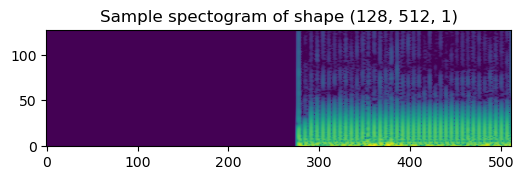

In [4]:

test_set_spectrogram =load_pkl(f'{PHYSIONET_SPECTOGRAM_OUT_DIR}/physionet_test.pkl')
print(type(test_set_spectrogram))
print(test_set_spectrogram.keys())
print(test_set_spectrogram['x'].shape)
# test_set_spectrogram is an array of elements who individually are of size (128,512). Lets concatenate these so its (n,128,512)
import matplotlib.pyplot as plt
# print one of the spectrograms
# x and y are EagerTensor
# lets plot it
x = test_set_spectrogram['x'][0];
# add dimension up front
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(x, cmap='viridis')
ax.set_title(f"Sample spectogram of shape {x.shape}")
ax.invert_yaxis()

# zoom into last 200 slices

plt.show()


The above took about <> time.